In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score


In [2]:
#Inflate pos predictions

def inflate_snp_predictions(pos_or_neg, fold_index=[0, 1, 2, 3], fold_suffixes=['', '', '', '']) :

    print("Inflating predictions for '" + pos_or_neg + "'.")
    
    df_folds = []
    
    sed_scores = None

    for fold_i, [fold_ix, fold_suffix] in enumerate(zip(fold_index, fold_suffixes)) :

        sed = h5py.File('/home/jlinder/borzoi_sc/borzoi/examples/saved_models/f3c' + str(fold_ix) + fold_suffix + '/paqtl_pip70/merge_' + pos_or_neg + '/sed.h5', 'r')
        
        gene_id_mat = sed['gene'][()]
        snp_mat = sed['snp'][()]
        chr_mat = sed['chr'][()]
        pos_mat = sed['pos'][()]
        n_mat = sed['n'][()]
        dist_mat = sed['distance'][()]
        covr_mat = sed['COVRWIDE'][()]
        ref_allele_mat = sed['ref_allele'][()]
        alt_allele_mat = sed['alt_allele'][()]

        if fold_i == 0 :
            sed_scores = covr_mat.copy()[:, :]
        else :
            sed_scores += covr_mat.copy()[:, :]
        
        gene_ids = []
        snps = []
        chroms = []
        poses = []
        ns = []
        distances = []
        covr_preds = []
        ref_alleles = []
        alt_alleles = []

        for i, si in enumerate(sed['si'][()].tolist()) :

            gene_ids.append(gene_id_mat[i].decode())
            snps.append(snp_mat[si].decode())
            chroms.append(chr_mat[si].decode())
            poses.append(int(pos_mat[si]))
            ns.append(int(n_mat[i]))
            distances.append(int(dist_mat[i]))

            covr_preds.append(np.mean(covr_mat[i, :]))

            ref_alleles.append(ref_allele_mat[si].decode())
            alt_alleles.append(alt_allele_mat[si].decode())

        df = pd.DataFrame({
            'gene_id_pred' : gene_ids,
            'snp' : snps,
            'chrom' : chroms,
            'pos' : poses,
            'n' : ns,
            'min_dist_pred' : distances,
            'delta_score' : covr_preds,
        })

        print("len(df) = " + str(len(df)))

        df_folds.append(df)

    df = df_folds[0]
    df = df.rename(columns={'delta_score' : 'delta_score_0'})
    df['delta_score'] = df['delta_score_0']
    
    for i in range(1, len(df_folds)) :

        df['delta_score_' + str(i)] = df_folds[i]['delta_score']
        df['delta_score'] += df['delta_score_' + str(i)]
        
    df['delta_score'] /= float(len(df_folds))
    
    sed_scores /= float(len(df_folds))
    
    df['row_index'] = np.arange(len(df), dtype=np.int32)
    
    #Get finemapped gene id and distance
    vcf_df = pd.read_csv('/home/jlinder/seqnn/data/qtl_cat/paqtl_pip70ea/' + pos_or_neg + '_merge.vcf', sep='\t', skiprows=4)
    
    vcf_df['min_dist'] = vcf_df['INFO'].apply(lambda x: x.split(";PD=")[1].split(";PI=")[0]).astype(int)
    vcf_df['finemap_gene_id'] = vcf_df['INFO'].apply(lambda x: x.split("MT=")[1].split(".")[0])
    vcf_df['matched_snp'] = vcf_df['INFO'].apply(lambda x: x.split("PI=")[1])
    
    df = df.join(vcf_df[['ID', 'min_dist', 'finemap_gene_id', 'matched_snp']].set_index('ID'), on='snp', how='inner').copy().reset_index(drop=True)
    
    df.loc[df['delta_score'].isnull(), 'delta_score'] = 0.
    
    return df, sed_scores

df_snp_pos, scores_pos = inflate_snp_predictions('pos', [0, 1, 2, 3], ['', '', '', ''])

#Rename borzoi VEP score
df_snp_pos = df_snp_pos.rename(columns={'delta_score' : 'delta_score_borzoi'})


Inflating predictions for 'pos'.
len(df) = 7409
len(df) = 7409
len(df) = 7409
len(df) = 7409


In [3]:
#Get target tissues

target_ids = h5py.File('/home/jlinder/borzoi_sc/borzoi/examples/saved_models/f3c0/paqtl_pip70/merge_pos/sed.h5', 'r')['target_ids'][()][-89:]
target_ids = [tid.decode() for tid in target_ids.tolist()]

target_name_dict = pd.read_csv('/home/jlinder/borzoi_sc/borzoi/examples/targets_gtex.txt', sep='\t')[['identifier', 'description']].set_index('identifier').to_dict(orient='index')

target_names = []
for tid in target_ids :
    target_names.append(target_name_dict[tid]['description'].split("NA:")[1])


In [4]:
#Collapse and average across tissue replicates

targets_name_arr = np.array(target_names, dtype=object)

tissue_map = [
    ['adipose_tissue', np.nonzero(targets_name_arr == 'adipose_tissue')[0].tolist()],
    ['adrenal_gland', np.nonzero(targets_name_arr == 'adrenal_gland')[0].tolist()],
    ['bladder', np.nonzero(targets_name_arr == 'bladder')[0].tolist()],
    ['blood', np.nonzero(targets_name_arr == 'blood')[0].tolist()],
    ['blood_vessel', np.nonzero(targets_name_arr == 'blood_vessel')[0].tolist()],
    ['bone_marrow', np.nonzero(targets_name_arr == 'bone_marrow')[0].tolist()],
    ['brain', np.nonzero(targets_name_arr == 'brain')[0].tolist()],
    ['breast', np.nonzero(targets_name_arr == 'breast')[0].tolist()],
    ['cervix_uteri', np.nonzero(targets_name_arr == 'cervix_uteri')[0].tolist()],
    ['colon', np.nonzero(targets_name_arr == 'colon')[0].tolist()],
    ['esophagus', np.nonzero(targets_name_arr == 'esophagus')[0].tolist()],
    ['fallopian_tube', np.nonzero(targets_name_arr == 'fallopian_tube')[0].tolist()],
    ['heart', np.nonzero(targets_name_arr == 'heart')[0].tolist()],
    ['kidney', np.nonzero(targets_name_arr == 'kidney')[0].tolist()],
    ['liver', np.nonzero(targets_name_arr == 'liver')[0].tolist()],
    ['lung', np.nonzero(targets_name_arr == 'lung')[0].tolist()],
    ['muscle', np.nonzero(targets_name_arr == 'muscle')[0].tolist()],
    ['nerve', np.nonzero(targets_name_arr == 'nerve')[0].tolist()],
    ['ovary', np.nonzero(targets_name_arr == 'ovary')[0].tolist()],
    ['pancreas', np.nonzero(targets_name_arr == 'pancreas')[0].tolist()],
    ['pituitary', np.nonzero(targets_name_arr == 'pituitary')[0].tolist()],
    ['prostate', np.nonzero(targets_name_arr == 'prostate')[0].tolist()],
    ['salivary_gland', np.nonzero(targets_name_arr == 'salivary_gland')[0].tolist()],
    ['skin', np.nonzero(targets_name_arr == 'skin')[0].tolist()],
    ['small_intestine', np.nonzero(targets_name_arr == 'small_intestine')[0].tolist()],
    ['spleen', np.nonzero(targets_name_arr == 'spleen')[0].tolist()],
    ['stomach', np.nonzero(targets_name_arr == 'stomach')[0].tolist()],
    ['testis', np.nonzero(targets_name_arr == 'testis')[0].tolist()],
    ['thyroid', np.nonzero(targets_name_arr == 'thyroid')[0].tolist()],
    ['uterus', np.nonzero(targets_name_arr == 'uterus')[0].tolist()],
    ['vagina', np.nonzero(targets_name_arr == 'vagina')[0].tolist()],
]

new_scores_pos = np.zeros((scores_pos.shape[0], len(tissue_map)))

new_target_names = []

tissue_dict = {}

for j, [new_target, old_targets] in enumerate(tissue_map) :
    
    for j_old in old_targets :
        new_scores_pos[:, j] += scores_pos[:, j_old]

    new_scores_pos[:, j] /= len(old_targets)
    
    new_target_names.append(new_target)
    
    tissue_dict[new_target] = j

scores_pos = new_scores_pos

target_names = new_target_names

print('target_names = ' + str(target_names))
print('scores_pos.shape = ' + str(scores_pos.shape))


target_names = ['adipose_tissue', 'adrenal_gland', 'bladder', 'blood', 'blood_vessel', 'bone_marrow', 'brain', 'breast', 'cervix_uteri', 'colon', 'esophagus', 'fallopian_tube', 'heart', 'kidney', 'liver', 'lung', 'muscle', 'nerve', 'ovary', 'pancreas', 'pituitary', 'prostate', 'salivary_gland', 'skin', 'small_intestine', 'spleen', 'stomach', 'testis', 'thyroid', 'uterus', 'vagina']
scores_pos.shape = (7409, 31)


In [5]:
#Filter on matched gene

df_snp_pos['gene_id_base'] = df_snp_pos['gene_id_pred'].apply(lambda x: x.split(".")[0])

df_snp_pos = df_snp_pos.query("gene_id_base == finemap_gene_id").copy().reset_index(drop=True)


In [6]:
#Sort by SNP

df_snp_pos = df_snp_pos.sort_values(by=['snp'], ascending=True).copy().reset_index(drop=True)

scores_pos = scores_pos[df_snp_pos['row_index'], :]

df_snp_pos['row_index'] = np.arange(len(df_snp_pos), dtype='int32')

print("len(df_snp_pos) = " + str(len(df_snp_pos)))
print("scores_pos.shape = " + str(scores_pos.shape))


len(df_snp_pos) = 1570
scores_pos.shape = (1570, 31)


In [7]:
#Determine which tissues each SNP is estimated to be causal within (positives only)

tissue_names = [
    ['adipose_subcutaneous', 'adipose_tissue', 'darkgreen'],
    ['adipose_visceral', 'adipose_tissue', 'darkgreen'],
    ['adrenal_gland', 'adrenal_gland', 'teal'],
    ['artery_aorta', 'blood_vessel', 'darkred'],
    ['artery_coronary', 'blood_vessel', 'darkred'],
    ['artery_tibial', 'blood_vessel', 'darkred'],
    ['blood', 'blood', 'red'],
    ['brain_amygdala', 'brain', 'gold'],
    ['brain_anterior_cingulate_cortex', 'brain', 'gold'],
    ['brain_caudate', 'brain', 'gold'],
    ['brain_cerebellar_hemisphere', 'brain', 'gold'],
    ['brain_cerebellum', 'brain', 'gold'],
    ['brain_cortex', 'brain', 'gold'],
    ['brain_frontal_cortex', 'brain', 'gold'],
    ['brain_hippocampus', 'brain', 'gold'],
    ['brain_hypothalamus', 'brain', 'gold'],
    ['brain_nucleus_accumbens', 'brain', 'gold'],
    ['brain_putamen', 'brain', 'gold'],
    ['brain_spinal_cord', 'brain', 'gold'],
    ['brain_substantia_nigra', 'brain', 'gold'],
    ['breast', 'breast', 'magenta'],
    ['colon_sigmoid', 'colon', 'brown'],
    ['colon_transverse', 'colon','brown'],
    ['esophagus_gej', 'esophagus', 'darkblue'],
    ['esophagus_mucosa', 'esophagus', 'darkblue'],
    ['esophagus_muscularis', 'esophagus', 'darkblue'],
    ['fibroblast', 'skin', 'lightbrown'],
    ['heart_atrial_appendage', 'heart', 'darkred'],
    ['heart_left_ventricle', 'heart', 'darkred'],
    ['kidney_cortex', 'kidney', 'darkbrown'],
    ['LCL', 'blood', 'red'],
    ['liver', 'liver', 'violet'],
    ['lung', 'lung', 'gray'],
    ['minor_salivary_gland', 'salivary_gland', 'orange'],
    ['muscle', 'muscle', 'black'],
    ['nerve_tibial', 'nerve', 'red'],
    ['ovary', 'ovary', 'magenta'],
    ['pancreas', 'pancreas', 'brown'],
    ['pituitary', 'pituitary', 'brown'],
    ['prostate', 'prostate', 'darkblue'],
    ['skin_not_sun_exposed', 'skin', 'lightbrown'],
    ['skin_sun_exposed', 'skin', 'lightbrown'],
    ['small_intestine', 'small_intestine', 'brown'],
    ['spleen', 'spleen', 'darkviolet'],
    ['stomach', 'stomach', 'brown'],
    ['testis', 'testis', 'darkblue'],
    ['thyroid', 'thyroid', 'lightgray'],
    ['uterus', 'uterus', 'magenta'],
    ['vagina', 'vagina', 'magenta']
]

snp_map_pos = {
    row['snp'] : i for i, [_, row] in enumerate(df_snp_pos.iterrows())
}

#Filter targets for used columns only
valid_targets = np.unique([tissue_name_curr[1] for tissue_name_curr in tissue_names]).tolist()

keep_index = np.nonzero([1 if target_name in set(valid_targets) else 0 for target_name in target_names])[0]

target_names = np.array(target_names, dtype=object)[keep_index].tolist()
scores_pos = scores_pos[:, keep_index]

target_map = {
    target : i for i, target in enumerate(target_names)
}

is_causal_pos_pip90 = np.zeros(scores_pos.shape, dtype='int32')
is_causal_pos_pip70 = np.zeros(scores_pos.shape, dtype='int32')
is_causal_pos_pip20 = np.zeros(scores_pos.shape, dtype='int32')

for [tissue_name, target_name, _] in tissue_names :
    
    #Load tissue-specific VCF file(s)
    vcf_df_pos_pip90 = pd.read_csv('/home/jlinder/seqnn/data/qtl_cat/paqtl_pip90ea/GTEx_txrev_' + tissue_name + '_pos.vcf', sep='\t', skiprows=4)
    vcf_df_pos_pip70 = pd.read_csv('/home/jlinder/seqnn/data/qtl_cat/paqtl_pip70ea/GTEx_txrev_' + tissue_name + '_pos.vcf', sep='\t', skiprows=4)
    vcf_df_pos_pip20 = pd.read_csv('/home/jlinder/seqnn/data/qtl_cat/paqtl_pip20ea/GTEx_txrev_' + tissue_name + '_pos.vcf', sep='\t', skiprows=4)
    
    print("-- " + tissue_name + " --")
    print("len(vcf_df_pos_pip90) = " + str(len(vcf_df_pos_pip90)))
    print("len(vcf_df_pos_pip70) = " + str(len(vcf_df_pos_pip70)))
    print("len(vcf_df_pos_pip20) = " + str(len(vcf_df_pos_pip20)))
    
    #Mark causal SNPs in label matrix (pip90)
    for _, row in vcf_df_pos_pip90.iterrows() :
        if row['ID'] in snp_map_pos and target_name in target_map :
            is_causal_pos_pip90[snp_map_pos[row['ID']], target_map[target_name]] += 1
    
    #Mark causal SNPs in label matrix (pip70)
    for _, row in vcf_df_pos_pip70.iterrows() :
        if row['ID'] in snp_map_pos and target_name in target_map :
            is_causal_pos_pip70[snp_map_pos[row['ID']], target_map[target_name]] += 1
    
    #Mark causal SNPs in label matrix (pip20)
    for _, row in vcf_df_pos_pip20.iterrows() :
        if row['ID'] in snp_map_pos and target_name in target_map :
            is_causal_pos_pip20[snp_map_pos[row['ID']], target_map[target_name]] += 1

print("scores_pos.shape = " + str(scores_pos.shape))
print("is_causal_pos_pip90.shape = " + str(is_causal_pos_pip90.shape))
print("is_causal_pos_pip70.shape = " + str(is_causal_pos_pip70.shape))
print("is_causal_pos_pip20.shape = " + str(is_causal_pos_pip20.shape))


-- adipose_subcutaneous --
len(vcf_df_pos_pip90) = 291
len(vcf_df_pos_pip70) = 380
len(vcf_df_pos_pip20) = 1176
-- adipose_visceral --
len(vcf_df_pos_pip90) = 218
len(vcf_df_pos_pip70) = 282
len(vcf_df_pos_pip20) = 863
-- adrenal_gland --
len(vcf_df_pos_pip90) = 99
len(vcf_df_pos_pip70) = 125
len(vcf_df_pos_pip20) = 430
-- artery_aorta --
len(vcf_df_pos_pip90) = 194
len(vcf_df_pos_pip70) = 251
len(vcf_df_pos_pip20) = 768
-- artery_coronary --
len(vcf_df_pos_pip90) = 89
len(vcf_df_pos_pip70) = 107
len(vcf_df_pos_pip20) = 385
-- artery_tibial --
len(vcf_df_pos_pip90) = 262
len(vcf_df_pos_pip70) = 335
len(vcf_df_pos_pip20) = 1015
-- blood --
len(vcf_df_pos_pip90) = 142
len(vcf_df_pos_pip70) = 193
len(vcf_df_pos_pip20) = 637
-- brain_amygdala --
len(vcf_df_pos_pip90) = 37
len(vcf_df_pos_pip70) = 48
len(vcf_df_pos_pip20) = 181
-- brain_anterior_cingulate_cortex --
len(vcf_df_pos_pip90) = 42
len(vcf_df_pos_pip70) = 56
len(vcf_df_pos_pip20) = 272
-- brain_caudate --
len(vcf_df_pos_pip90) = 68

In [8]:
#Load GTEX v8 TPM matrix

#Define tissue column-to-file mapping
tissue_to_file_dict = {
    'Adipose - Subcutaneous' : 'adipose_subcutaneous',
    'Adipose - Visceral (Omentum)' : 'adipose_visceral',
    'Adrenal Gland' : 'adrenal_gland',
    'Artery - Aorta' : 'artery_aorta',
    'Artery - Coronary' : 'artery_coronary',
    'Artery - Tibial' : 'artery_tibial',
    'Whole Blood' : 'blood',
    'Brain - Amygdala' : 'brain_amygdala',
    'Brain - Anterior cingulate cortex (BA24)' : 'brain_anterior_cingulate_cortex',
    'Brain - Caudate (basal ganglia)' : 'brain_caudate',
    'Brain - Cerebellar Hemisphere' : 'brain_cerebellar_hemisphere',
    'Brain - Cerebellum' : 'brain_cerebellum',
    'Brain - Cortex' : 'brain_cortex',
    'Brain - Frontal Cortex (BA9)' : 'brain_frontal_cortex',
    'Brain - Hippocampus' : 'brain_hippocampus',
    'Brain - Hypothalamus' : 'brain_hypothalamus',
    'Brain - Nucleus accumbens (basal ganglia)' : 'brain_nucleus_accumbens',
    'Brain - Putamen (basal ganglia)' : 'brain_putamen',
    'Brain - Spinal cord (cervical c-1)' : 'brain_spinal_cord',
    'Brain - Substantia nigra' : 'brain_substantia_nigra',
    'Breast - Mammary Tissue' : 'breast',
    'Colon - Sigmoid' : 'colon_sigmoid',
    'Colon - Transverse' : 'colon_transverse',
    'Esophagus - Gastroesophageal Junction' : 'esophagus_gej',
    'Esophagus - Mucosa' : 'esophagus_mucosa',
    'Esophagus - Muscularis' : 'esophagus_muscularis',
    'Cells - Cultured fibroblasts' : 'fibroblast',
    'Heart - Atrial Appendage' : 'heart_atrial_appendage',
    'Heart - Left Ventricle' : 'heart_left_ventricle',
    'Kidney - Cortex' : 'kidney_cortex',
    'Cells - EBV-transformed lymphocytes' : 'LCL',
    'Liver' : 'liver',
    'Lung' : 'lung',
    'Minor Salivary Gland' : 'minor_salivary_gland',
    'Muscle - Skeletal' : 'muscle',
    'Nerve - Tibial' : 'nerve_tibial',
    'Ovary' : 'ovary',
    'Pancreas' : 'pancreas',
    'Pituitary' : 'pituitary',
    'Prostate' : 'prostate',
    'Skin - Not Sun Exposed (Suprapubic)' : 'skin_not_sun_exposed',
    'Skin - Sun Exposed (Lower leg)' : 'skin_sun_exposed',
    'Small Intestine - Terminal Ileum' : 'small_intestine',
    'Spleen' : 'spleen',
    'Stomach' : 'stomach',
    'Testis' : 'testis',
    'Thyroid' : 'thyroid',
    'Uterus' : 'uterus',
    'Vagina' : 'vagina',
}

#Get inverse dictionary lookup
file_to_tissue_dict = {val : key for key, val in tissue_to_file_dict.items()}

#Load TPM matrix
tpm_df = pd.read_csv("/home/jlinder/seqnn/data/diff_expr/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz", sep='\t', compression='gzip', skiprows=2)

#Clean dataframe
tpm_df['gene_id'] = tpm_df['Name']
tpm_df['gene_symbol'] = tpm_df['Description']
tpm_df['gene_base'] = tpm_df['gene_id'].apply(lambda x: x.split(".")[0])

tpm_df = tpm_df.drop_duplicates(subset=['gene_base'], keep='first').copy().reset_index(drop=True)

#Initialize target columns in dataframe
for target_name in target_names :
    tpm_df[target_name + '_tpm'] = 0.
    tpm_df[target_name + '_n'] = 0.

#Loop over all tissue entries in TPM matrix, truncate outliers and append log2-normalized metric
tissue_cols = []

for [tissue_name, target_name, _] in tissue_names :
    
    #Get long name
    tissue = file_to_tissue_dict[tissue_name]
    
    #Accumulate in target column
    tpm_df[target_name + '_tpm'] += tpm_df[tissue]
    tpm_df[target_name + '_n'] += 1.
    
    tissue_cols.append(target_name + '_tpm')

#Normalize target columns (average across related tissues)
for target_name in target_names :
    tpm_df[target_name + '_tpm'] /= tpm_df[target_name + '_n']

tpm_df = tpm_df[['gene_id', 'gene_base', 'gene_symbol'] + sorted(list(set(tissue_cols)))]

tpm_df['gene_base'] = tpm_df['gene_id'].apply(lambda x: x.split('.')[0] if '.' in x else x)
tpm_df = tpm_df.loc[tpm_df['gene_id'].str.contains("ENS")].drop_duplicates(subset=['gene_base'], keep='first').copy().reset_index(drop=True)

print("len(tpm_df) = " + str(len(tpm_df)))


len(tpm_df) = 56156


In [9]:
#Compute TPM ranks for non-zero entries, per target

for target_name in target_names :
    
    if target_name + '_tpm' in set(tpm_df.columns.values.tolist()) :    
        target_df_nonzero = tpm_df.query(target_name + "_tpm > 0.").copy().reset_index(drop=True)

        #Compute TPM rank
        target_df_nonzero[target_name + '_rank'] = np.argsort(np.argsort(target_df_nonzero[target_name + '_tpm'].values)) / float(len(target_df_nonzero))

        tpm_df = tpm_df.join(target_df_nonzero[['gene_id', target_name + '_rank']].set_index('gene_id'), on='gene_id', how='left').copy().reset_index(drop=True)
        tpm_df.loc[tpm_df[target_name + '_rank'].isnull(), target_name + '_rank'] = 0.

#Re-sort dataframe
tpm_df = tpm_df.sort_values(by='gene_id', ascending=True).copy().reset_index(drop=True)

print("len(tpm_df) = " + str(len(tpm_df)))


len(tpm_df) = 56156


In [10]:
#Augment SNP dataframe with gene tpms and ranks, per target

df_snp_pos = df_snp_pos.join(tpm_df.set_index('gene_base'), on='gene_id_base', how='left').copy().reset_index(drop=True)
df_snp_pos = df_snp_pos.sort_values(by='row_index', ascending=True).copy().reset_index(drop=True)

for target_name in target_names :
    if target_name + '_tpm' in set(df_snp_pos.columns.values.tolist()) :
        df_snp_pos.loc[df_snp_pos[target_name + '_tpm'].isnull(), target_name + '_tpm'] = 0.
        df_snp_pos.loc[df_snp_pos[target_name + '_rank'].isnull(), target_name + '_rank'] = 0.

print("len(df_snp_pos) = " + str(len(df_snp_pos)))


len(df_snp_pos) = 1570


--- brain vs blood ---
 - min_pos_actual = 2
 - min_neg_actual = 1
APR = 1.82
 - n_pos = 74
 - n_neg = 351


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


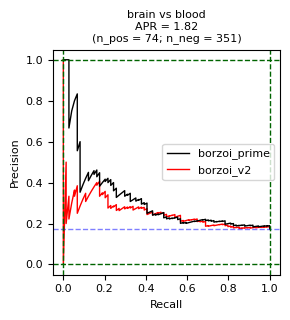

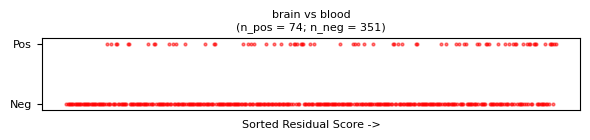

In [12]:
#Pair-wise tissue specificity analysis

#Tissue pairs to compare
tissue_pairs = [
    ['brain', 'blood'],
]

#Parameters
is_causal_hi = is_causal_pos_pip70
is_causal_lo = is_causal_pos_pip20

neg_mode = 'shared' #or 'distinct'
min_tpm = 0.
min_rank = 0.05
min_pos = 2
min_neg = 1
min_conf = 0.

#Loop over tissue pairs
for tissue_pair_i, [tissue_1, tissue_2] in enumerate(tissue_pairs) :
    
    print("--- " + str(tissue_1) + " vs " + str(tissue_2) + " ---")
    
    #Determine largest possible cutoff on causal labels for individual tissues
    min_pos_actual = min(min_pos, np.max(is_causal_hi[:, [target_map[tissue_1]]]))
    min_neg_actual = min(min_neg, np.max(is_causal_lo[:, [target_map[tissue_2]]]))
    
    print(" - min_pos_actual = " + str(min_pos_actual))
    print(" - min_neg_actual = " + str(min_neg_actual))
    
    #Determine positives
    tissue_1_positives = (np.sum(is_causal_hi[:, [target_map[tissue_1]]], axis=-1) >= min_pos_actual) & (np.sum(is_causal_lo[:, [target_map[tissue_2]]], axis=-1) == 0)
    
    #Determine negatives
    tissue_1_negatives = None
    if neg_mode == 'shared' :
        tissue_1_negatives = (np.sum(is_causal_lo[:, [target_map[tissue_2]]], axis=-1) >= min_neg_actual)
    elif neg_mode == 'distinct' :
        tissue_1_negatives = (np.sum(is_causal_lo[:, [target_map[tissue_2]]], axis=-1) >= min_neg_actual) & (np.sum(is_causal_lo[:, [target_map[tissue_1]]], axis=-1) == 0)

    #Build label matrix
    tissue_1_vs_tissue_2 = np.concatenate([
        tissue_1_positives[:, None],
        tissue_1_negatives[:, None],
    ], axis=-1, dtype='int32')

    #Build score matrix
    tissue_1_vs_tissue_2_scores = scores_pos[:, [target_map[tissue_1], target_map[tissue_2]]]

    #Get auxiliary measures
    tissue_1_tpm = df_snp_pos[tissue_1 + '_tpm'].values
    tissue_1_rank = df_snp_pos[tissue_1 + '_rank'].values
    tissue_2_tpm = df_snp_pos[tissue_2 + '_tpm'].values
    tissue_2_rank = df_snp_pos[tissue_2 + '_rank'].values

    #Get tissue-agnostic maximum effect predictions
    fc = np.maximum(tissue_1_vs_tissue_2_scores[:, 0], tissue_1_vs_tissue_2_scores[:, 1])
    fc_qtl = np.quantile(fc, q=min_conf)
    
    #Get filter
    keep_index = (np.sum(tissue_1_vs_tissue_2, axis=-1) >= 1)
    keep_index = keep_index & ((((tissue_1_tpm > min_tpm) & (tissue_1_rank >= min_rank)) & ((tissue_2_tpm > min_tpm) & (tissue_2_rank >= min_rank))) & (fc >= fc_qtl))
    keep_index = np.nonzero(keep_index)[0]

    #Filter data
    tissue_1_vs_tissue_2_df = df_snp_pos.iloc[keep_index].copy()
    tissue_1_vs_tissue_2 = tissue_1_vs_tissue_2[keep_index, ...]
    tissue_1_vs_tissue_2_scores = tissue_1_vs_tissue_2_scores[keep_index, ...]

    #Get final scores and labels
    score = tissue_1_vs_tissue_2_scores[:, 0] - tissue_1_vs_tissue_2_scores[:, 1]
    label = np.maximum(tissue_1_vs_tissue_2[:, 0] - tissue_1_vs_tissue_2[:, 1], 0)

    #Precision-recall scores
    ap = average_precision_score(label, score)

    prc, rec, _ = precision_recall_curve(label, score)
    
    prc_other = np.load('/home/jlinder/borzoi-paper/analysis/paqtl/paqtl_pip70_' + tissue_1 + '_vs_' + tissue_2 + '_prc.npy')
    rec_other = np.load('/home/jlinder/borzoi-paper/analysis/paqtl/paqtl_pip70_' + tissue_1 + '_vs_' + tissue_2 + '_rec.npy')

    print("APR = " + str(round(ap / np.mean(label), 3)))

    print(" - n_pos = " + str(np.sum(label)))
    print(" - n_neg = " + str(label.shape[0] - np.sum(label)))

    f = plt.figure(figsize=(3, 3.3))

    l1 = plt.plot(rec, prc, linestyle='-', color='black', linewidth=1, label='borzoi_prime')
    l2 = plt.plot(rec_other, prc_other, linestyle='-', color='red', linewidth=1, label='borzoi_v2', zorder=-1)
    
    plt.axhline(y=np.mean(label), color='blue', linestyle='--', linewidth=1, alpha=0.5)

    plt.axhline(y=0., linestyle='--', linewidth=1., color='darkgreen')
    plt.axvline(x=0., linestyle='--', linewidth=1., color='darkgreen')

    plt.axhline(y=1., linestyle='--', linewidth=1., color='darkgreen')
    plt.axvline(x=1., linestyle='--', linewidth=1., color='darkgreen')

    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)

    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=8)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=8)

    plt.xlabel("Recall", fontsize=8)
    plt.ylabel("Precision", fontsize=8)
    
    plt.title(str(tissue_1[:10]) + " vs " + str(tissue_2[:10]) + "\nAPR = " + str(round(ap / np.mean(label), 3)) + "\n(n_pos = " + str(np.sum(label)) + "; n_neg = " + str(label.shape[0] - np.sum(label)) + ")", fontsize=8)
    
    plt.legend(handles=[l1[0], l2[0]], fontsize=8)
    
    plt.tight_layout()
    
    plt.savefig('borzoi_prime_paqtl_specificity_' + tissue_1 + '_vs_' + tissue_2 + '.eps')

    plt.show()

    label_sorted = label[np.argsort(score)]

    f = plt.figure(figsize=(6, 1.5))

    plt.scatter(np.arange(label_sorted.shape[0]), label_sorted, color='red', s=4, alpha=0.5)
    
    plt.xticks([], [])
    plt.yticks([0, 1], ['Neg', 'Pos'], fontsize=8)
    
    plt.ylim(-0.1, 1.1)

    plt.xlabel("Sorted Residual Score ->", fontsize=8)
    
    plt.title(str(tissue_1[:10]) + " vs " + str(tissue_2[:10]) + "\n(n_pos = " + str(np.sum(label)) + "; n_neg = " + str(label.shape[0] - np.sum(label)) + ")", fontsize=8)
    
    plt.tight_layout()

    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


--- brain ---
 - min_pos_actual = 1
 - min_neg_actual = 1
APR = 1.669
 - n_pos = 93
 - n_neg = 647


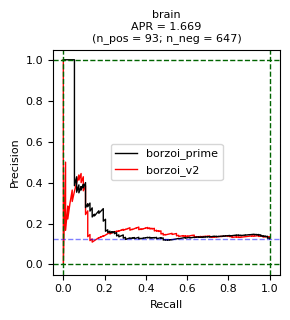

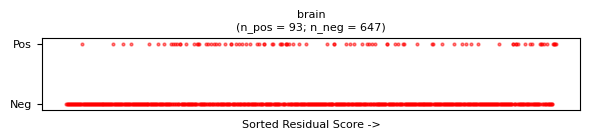

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


--- testis ---
 - min_pos_actual = 1
 - min_neg_actual = 1
APR = 1.311
 - n_pos = 83
 - n_neg = 757


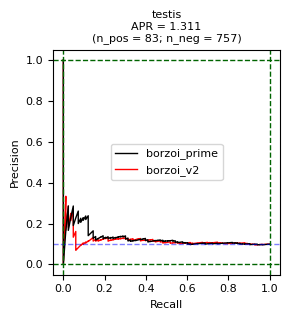

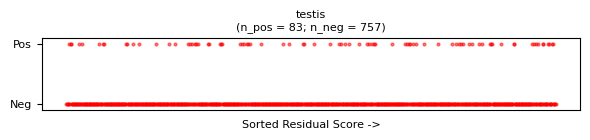

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


--- thyroid ---
 - min_pos_actual = 1
 - min_neg_actual = 1
APR = 1.675
 - n_pos = 64
 - n_neg = 568


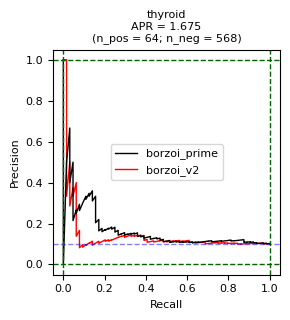

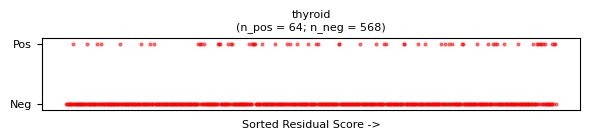

In [13]:
#Tissue specificity analysis compared against a subset of neutral tissues

#Neutral tissues
neg_tissues = [
    'adipose_tissue',
    'blood',
    'skin',
]

#Tissues to compare against neutral tissues
tissues = [
    'brain',
    'testis',
    'thyroid',
]

#Parameters
is_causal_hi = is_causal_pos_pip70
is_causal_lo = is_causal_pos_pip20

neg_mode = 'distinct' #or 'distinct'
min_tpm = 0.
min_rank = 0.05
min_pos = 1
min_neg = 1
min_conf = 0.

neg_tissue_index = np.nonzero(np.array([1 if target_name in set(neg_tissues) else 0 for target_name in target_names], dtype='int32'))[0]

#Loop over tissue pairs
for tissue_i, tissue in enumerate(tissues) :
    
    print("--- " + str(tissue) + " ---")
    
    #Determine largest possible cutoff on causal labels for individual tissues
    min_pos_actual = min(min_pos, np.max(np.sum(is_causal_hi[:, [target_map[tissue]]], axis=-1)))
    min_neg_actual = min(min_neg, np.max(np.sum(is_causal_lo[:, neg_tissue_index], axis=-1)))
    
    print(" - min_pos_actual = " + str(min_pos_actual))
    print(" - min_neg_actual = " + str(min_neg_actual))
    
    #Determine positives
    tissue_positives = (np.sum(is_causal_hi[:, [target_map[tissue]]], axis=-1) >= min_pos_actual) & (np.sum(is_causal_lo[:, neg_tissue_index], axis=-1) == 0)
    
    #Determine negatives
    tissue_negatives = None
    if neg_mode == 'shared' :
        tissue_negatives = (np.sum(is_causal_lo[:, neg_tissue_index], axis=-1) >= min_neg_actual)
    elif neg_mode == 'distinct' :
        tissue_negatives = (np.sum(is_causal_lo[:, neg_tissue_index], axis=-1) >= min_neg_actual) & (np.sum(is_causal_lo[:, [target_map[tissue]]], axis=-1) == 0)

    #Build label matrix
    tissue_vs_others = np.concatenate([
        tissue_positives[:, None],
        tissue_negatives[:, None],
    ], axis=-1, dtype='int32')

    #Build score matrix
    tissue_vs_others_scores = np.concatenate([
        scores_pos[:, [target_map[tissue]]],
        np.mean(scores_pos[:, neg_tissue_index], axis=-1)[:, None],
    ], axis=-1)

    #Get auxiliary measures
    tissue_tpm = df_snp_pos[tissue + '_tpm'].values
    tissue_rank = df_snp_pos[tissue + '_rank'].values
    
    tpms = np.zeros(scores_pos.shape, dtype='float32')
    ranks = np.zeros(scores_pos.shape, dtype='float32')

    for target_name in target_names :
        if target_name + '_tpm' in set(df_snp_pos.columns.values.tolist()) :
            tpms[:, target_map[target_name]] = np.copy(df_snp_pos[target_name + '_tpm'].values)
            ranks[:, target_map[target_name]] = np.copy(df_snp_pos[target_name + '_rank'].values)

    others_tpm = np.min(tpms[:, neg_tissue_index], axis=-1)
    others_rank = np.mean(ranks[:, neg_tissue_index], axis=-1)

    #Get tissue-agnostic maximum effect predictions
    fc = np.maximum(tissue_vs_others_scores[:, 0], tissue_vs_others_scores[:, 1])
    fc_qtl = np.quantile(fc, q=min_conf)
    
    #Get filter
    keep_index = (np.sum(tissue_vs_others, axis=-1) >= 1)
    keep_index = keep_index & ((((tissue_tpm > min_tpm) & (tissue_rank >= min_rank)) & ((others_tpm > min_tpm) & (others_rank >= min_rank))) & (fc >= fc_qtl))
    keep_index = np.nonzero(keep_index)[0]

    #Filter data
    tissue_vs_others_df = df_snp_pos.iloc[keep_index].copy()
    tissue_vs_others = tissue_vs_others[keep_index, ...]
    tissue_vs_others_scores = tissue_vs_others_scores[keep_index, ...]

    #Get final scores and labels
    score = tissue_vs_others_scores[:, 0] - tissue_vs_others_scores[:, 1]
    label = np.maximum(tissue_vs_others[:, 0] - tissue_vs_others[:, 1], 0)

    #Precision-recall scores
    ap = average_precision_score(label, score)

    prc, rec, _ = precision_recall_curve(label, score)
    
    prc_other = np.load('/home/jlinder/borzoi-paper/analysis/paqtl/paqtl_pip70_' + tissue + '_vs_others_prc.npy')
    rec_other = np.load('/home/jlinder/borzoi-paper/analysis/paqtl/paqtl_pip70_' + tissue + '_vs_others_rec.npy')

    print("APR = " + str(round(ap / np.mean(label), 3)))

    print(" - n_pos = " + str(np.sum(label)))
    print(" - n_neg = " + str(label.shape[0] - np.sum(label)))

    f = plt.figure(figsize=(3, 3.3))

    l1 = plt.plot(rec, prc, linestyle='-', color='black', linewidth=1, label='borzoi_prime')
    l2 = plt.plot(rec_other, prc_other, linestyle='-', color='red', linewidth=1, label='borzoi_v2', zorder=-1)
    
    plt.axhline(y=np.mean(label), color='blue', linestyle='--', linewidth=1, alpha=0.5)

    plt.axhline(y=0., linestyle='--', linewidth=1., color='darkgreen')
    plt.axvline(x=0., linestyle='--', linewidth=1., color='darkgreen')

    plt.axhline(y=1., linestyle='--', linewidth=1., color='darkgreen')
    plt.axvline(x=1., linestyle='--', linewidth=1., color='darkgreen')

    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)

    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=8)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=8)

    plt.xlabel("Recall", fontsize=8)
    plt.ylabel("Precision", fontsize=8)
    
    plt.title(str(tissue[:10]) + "\nAPR = " + str(round(ap / np.mean(label), 3)) + "\n(n_pos = " + str(np.sum(label)) + "; n_neg = " + str(label.shape[0] - np.sum(label)) + ")", fontsize=8)
    
    plt.legend(handles=[l1[0], l2[0]], fontsize=8)
    
    plt.tight_layout()
    
    plt.savefig('borzoi_prime_paqtl_specificity_' + tissue + '.eps')

    plt.show()

    label_sorted = label[np.argsort(score)]

    f = plt.figure(figsize=(6, 1.5))

    plt.scatter(np.arange(label_sorted.shape[0]), label_sorted, color='red', s=4, alpha=0.5)
    
    plt.xticks([], [])
    plt.yticks([0, 1], ['Neg', 'Pos'], fontsize=8)
    
    plt.ylim(-0.1, 1.1)

    plt.xlabel("Sorted Residual Score ->", fontsize=8)
    
    plt.title(str(tissue[:10]) + "\n(n_pos = " + str(np.sum(label)) + "; n_neg = " + str(label.shape[0] - np.sum(label)) + ")", fontsize=8)
    
    plt.tight_layout()

    plt.show()
